Reference: https://www.kaggle.com/competitions/bike-sharing-demand/overview

In [154]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

plt.rcParams["axes.unicode_minus"] = False
plt.rc("font", family="NanumGothicCoding")


In [157]:
train = pd.read_csv('../../data/bicycle_train.csv') 
test = pd.read_csv('../../data/bicycle_test.csv')   

# test_datetime을 제출 파일 생성을 위해 미리 저장
test_datetime_for_submission = test['datetime']

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [159]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### datetime

`datetime`이 현재 object이므로 가공 필요

In [160]:
for dataset in [train, test]:
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset['year'] = dataset['datetime'].dt.year
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.day
    dataset['hour'] = dataset['datetime'].dt.hour
    dataset['dayofweek'] = dataset['datetime'].dt.dayofweek # 요일 추가
    
train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


### season에 따른 자전거 대여 빈도 확인

Text(0.5, 1.0, 'Season에 따른 자전거 대여 빈도')

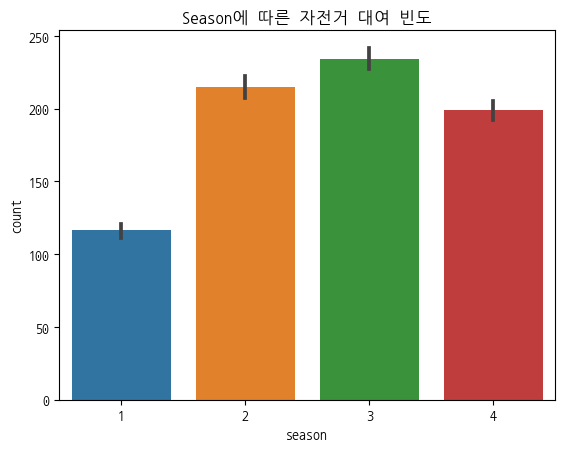

In [161]:
sns.barplot(data = train, x = "season", y = "count")
plt.title("Season에 따른 자전거 대여 빈도")

## 가을 > 여름 > 겨울 > 봄 순서로 많다. 생각보다 봄에 자전거 타는 빈도가 적다.

### 주말 제외한 국경일 등의 휴일과 주중의 자전거 대여 수 비교

Text(0.5, 1.0, '주말 및 공휴일과 주중의 자전거 대여 수 비교')

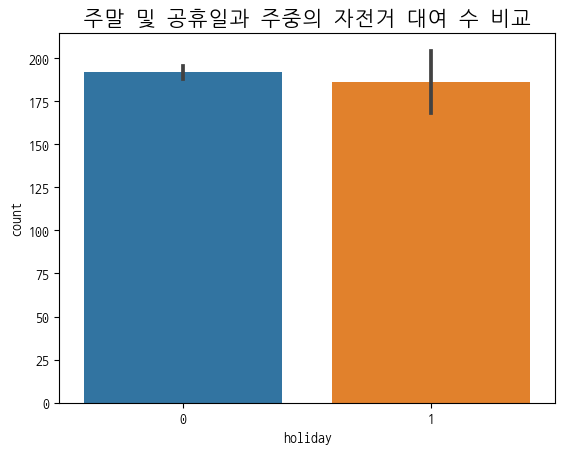

In [162]:
sns.barplot(data = train, x = "holiday", y = 'count')

plt.title("주말 및 공휴일과 주중의 자전거 대여 수 비교", fontsize = 15)

# 토 일 주말을 제외한 국경일 등의 휴일과 휴일이 아닌 날의 대여 수는 비슷하다.
# 휴일이 아닌 날이 휴일보다 빈도가 조금 더 높다. 

### 주말과 주중의 자전거 대여 수 비교

Text(0.5, 1.0, '주말과 주중의 자전거 대여 수 비교')

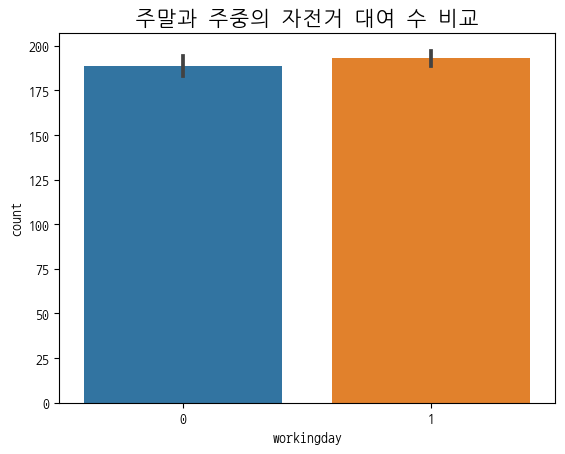

In [163]:
sns.barplot(data = train, x = "workingday", y = 'count')

plt.title("주말과 주중의 자전거 대여 수 비교", fontsize = 15)

### 전체적인 데이터의 자전거 대여 빈도 시각화

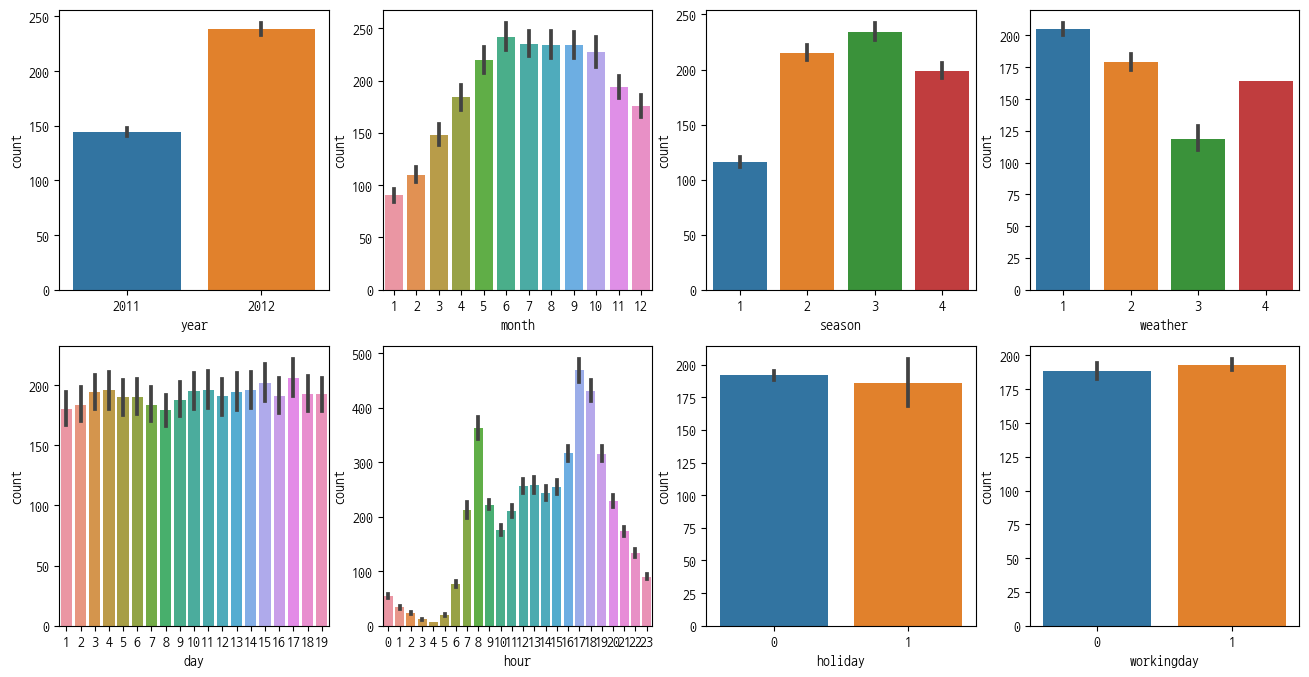

In [164]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))

cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화

for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i % 4
  
  sns.barplot(data = train, x = feature, y = 'count', ax = axs[row][col])

### 손실 함수 정의

- 성능 평가 방법은 RMSLE(Root Mean Square Log Error)이므로 오류 값의 로그에 대한 RMSE이다.
- scikit-learn에서는 RMSLE를 제공하지 않으므로 따로 사용자 정의

In [ ]:
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  
  return rmsle

def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = np.sqrt(mean_squared_error(y, pred))
  mae_val = mean_absolute_error(y, pred)
  
  print(f"RMSLE: {rmsle_val:.3f} | RMSE: {rmse_val:.3f} | MAE: {mae_val:.3f}")

### 데이터 전처리

- 모델 적용 전, 데이터가 정규분포로 되어 있는지 확인 
- 카테고리 피처에 대해 원-핫 인코딩으로 피처 인코딩

<AxesSubplot:>

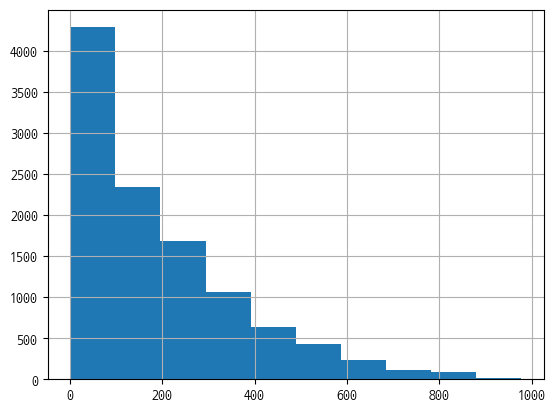

In [166]:
y.hist()

<AxesSubplot:>

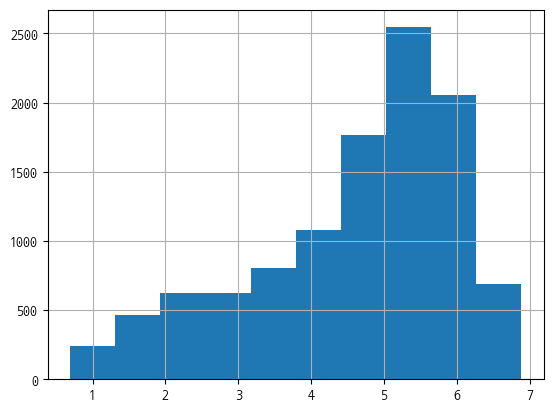

In [168]:
# 'count' 컬럼은 훈련 데이터의 타겟이므로 따로 분리하고, 로그 변환을 적용
# 자전거 대여량은 비대칭 분포이므로 np.log1p를 사용해 정규 분포에 가깝게 만듦
y_log_transform = np.log1p(train['count'])
y_log_transform.hist()

In [170]:
# 훈련 데이터에서 불필요한 컬럼 제거: 'count', 'casual', 'registered'
# casual + registerd = count 이므로 제거 
features_to_drop_train = ['count', 'casual', 'registered', 'datetime']
train_processed = train.drop(features_to_drop_train, axis=1)

# 테스트 데이터에서 불필요한 컬럼 제거: 'datetime'
features_to_drop_test = ['datetime']
test_processed = test.drop(features_to_drop_test, axis=1)

### 원-핫 인코딩

In [171]:
all_data_for_ohe = pd.concat([train_processed, test_processed], ignore_index=True)

# 원-핫 인코딩할 범주형 컬럼 리스트
ohe_cols = ['year', 'month', 'hour', 'dayofweek', 'holiday', 'workingday', 'season', 'weather']

# 합쳐진 데이터에 pd.get_dummies() 적용
all_data_ohe = pd.get_dummies(all_data_for_ohe, columns=ohe_cols, dtype=int)

### 데이터 분리

In [172]:
# 다시 훈련 데이터와 테스트 데이터로 분리
X = all_data_ohe.iloc[:len(train_processed)]
test_final_for_prediction = all_data_ohe.iloc[len(train_processed):]

# test_final_for_prediction의 인덱스를 원본 test 데이터의 인덱스로 재설정해야 인덱스 일치
test_final_for_prediction.index = test_processed.index

# 분리된 데이터의 피처 개수 확인 (이 두 값이 같아야 합니다!)
print(f"훈련 데이터 피처 개수 (X.shape[1]): {X.shape[1]}")
print(f"테스트 데이터 피처 개수 (test_final_for_prediction.shape[1]): {test_final_for_prediction.shape[1]}")

훈련 데이터 피처 개수 (X.shape[1]): 62
테스트 데이터 피처 개수 (test_final_for_prediction.shape[1]): 62


### 모델 선정 및 학습

In [175]:
X_train, X_val, y_train, y_val = train_test_split(X, y_log_transform, test_size=0.2, random_state=42)

# 다양한 회귀 모델 정의
models = {
    "LinearRegression": LinearRegression(), 
    "RandomForestRegressor": RandomForestRegressor(n_estimators=500, random_state=42),
    "XGBRegressor": XGBRegressor(n_estimators=500, random_state=42),
    "LGBMRegressor": LGBMRegressor(n_estimators=500, random_state=42)
}

print("\n--- 각 모델의 검증 성능 평가 ---")
for name, model in models.items():
    print(f"### {name} ###")
    model.fit(X_train, y_train)
    val_pred_raw = model.predict(X_val)
    # 평가를 위해 예측 결과와 실제 값을 np.expm1으로 변환하여 원래 스케일로 변환 
    val_pred = np.expm1(val_pred_raw)
    y_val_original = np.expm1(y_val)
    
    # # 모델별 피처들의 회귀계수 영향도 시각화 
    # coef = pd.Series(model.coef_, index = X.columns)
    # coef_sort = coef.sort_values(ascending = False)
    # sns.barplot(x = coef_sort.values, y = coef_sort.index)
    
    evaluate_regr(y_val_original, val_pred)
    print("-" * 30)


--- 각 모델의 검증 성능 평가 ---
### LinearRegression ###
  - RMLSE: 0.5809
  - RMSE: 95.0898
  - MAE: 61.7584
------------------------------
### RandomForestRegressor ###
  - RMLSE: 0.3292
  - RMSE: 44.9201
  - MAE: 27.2622
------------------------------
### XGBRegressor ###
  - RMLSE: 0.3113
  - RMSE: 43.8545
  - MAE: 26.9669
------------------------------
### LGBMRegressor ###
  - RMLSE: 0.2913
  - RMSE: 40.3786
  - MAE: 24.5144
------------------------------


### XGBoost, RGBM, RandomForest 앙상블 

In [182]:
# 7. 테스트 데이터 예측 및 앙상블
print("\n--- 테스트 데이터 최종 예측 및 앙상블 ---")

# 모든 모델을 전체 훈련 데이터(X, y_log_transform)로 다시 훈련
final_rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
final_xgb_model = XGBRegressor(n_estimators=500, random_state=42)
final_lgbm_model = LGBMRegressor(n_estimators=500, random_state=42)

final_rf_model.fit(X, y_log_transform)
final_xgb_model.fit(X, y_log_transform)
final_lgbm_model.fit(X, y_log_transform)

# 테스트 데이터에 대한 예측 수행
rf_test_pred_raw = final_rf_model.predict(test_final_for_prediction)
xgb_test_pred_raw = final_xgb_model.predict(test_final_for_prediction)
lgbm_test_pred_raw = final_lgbm_model.predict(test_final_for_prediction)

# 로그 변환된 예측값을 원래 스케일로 되돌립니다.
rf_test_pred = np.expm1(rf_test_pred_raw)
xgb_test_pred = np.expm1(xgb_test_pred_raw)
lgbm_test_pred = np.expm1(lgbm_test_pred_raw)


--- 테스트 데이터 최종 예측 및 앙상블 ---


In [183]:
# 앙상블 
final_ensemble_predictions = (rf_test_pred + xgb_test_pred + lgbm_test_pred) / 3

# 자전거 대여량은 음수가 될 수 없으므로, 예측값이 음수이면 0으로 
final_ensemble_predictions[final_ensemble_predictions < 0] = 0

In [184]:
submission = pd.DataFrame({
    'datetime': test_datetime_for_submission, # 미리 저장해둔 test_datetime 사용
    'count': final_ensemble_predictions
})

submission.to_csv('submission.csv', index=False)

print('\n--- 제출 파일 "submission.csv"가 성공적으로 생성되었습니다! ---')


--- 제출 파일 "submission.csv"가 성공적으로 생성되었습니다! ---


### 선형 회귀에서의 회귀계수별 영향도 시각화

In [185]:
from sklearn.linear_model import Ridge, Lasso

y_log_transform = np.log1p(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_log_transform, test_size = 0.3, random_state = 42)

def get_model_predict(model, X_train, X_val, y_train, y_val, is_expm1 = False):
  model.fit(X_train, y_train)
  pred = model.predict(X_val)
  if is_expm1:
    y_val = np.expm1(y_val)
    pred = np.expm1(pred)
    
  print(f"###{model.__class__.__name__}###")
  evaluate_regr(y_val, pred)
  
lr_reg = LinearRegression()
#ridge_reg = Ridge(alpha = 10)
#lasso_reg = Lasso(alpha = 0.01)

get_model_predict(lr_reg, X_train.values, X_val.values, y_train.values, y_val.values, is_expm1 = True)

###LinearRegression###
  - RMLSE: 0.5808
  - RMSE: 96.7439
  - MAE: 62.7767


<AxesSubplot:>

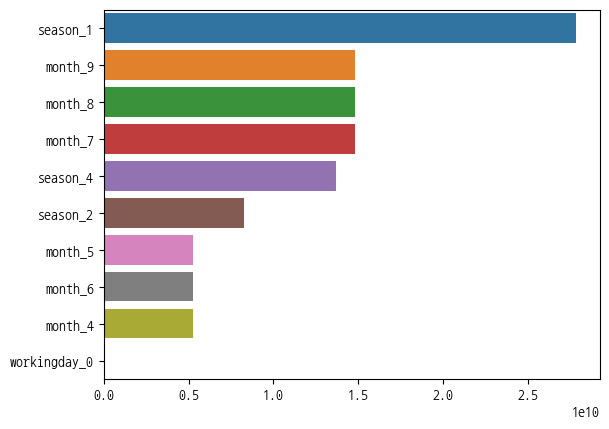

In [186]:
coef = pd.Series(lr_reg.coef_, index = X.columns)
coef_sort = coef.sort_values(ascending = False).head(10)
sns.barplot(x = coef_sort.values, y = coef_sort.index)